In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as s
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import itertools

import datetime
import pickle

In [2]:
pd.set_option("display.float_format", "{:.4f}".format)

In [3]:
#Load database

url = 'C:/Users/plhurno/OneDrive - Essity/Priv'
df = pd.read_csv(url + '/household_power_consumption.txt', sep=";", na_values=['nan', '?'], low_memory = False, infer_datetime_format=True, parse_dates={'Datestamp':[0,1]}, index_col=['Datestamp'])
df.reset_index(inplace=True)
df.head(3)

,Datestamp,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000
1,2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000,0.0000,1.0000,16.0000
2,2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000,0.0000,2.0000,17.0000


In [4]:
#database to analyse
df_seasons=pd.DataFrame(df, columns=['Datestamp', 'Global_active_power'])
df_seasons.head()

,Datestamp,Global_active_power
0,2006-12-16 17:24:00,4.2160
1,2006-12-16 17:25:00,5.3600
2,2006-12-16 17:26:00,5.3740
3,2006-12-16 17:27:00,5.3880
4,2006-12-16 17:28:00,3.6660


In [5]:
# % of na data 
df_seasons.isna().sum()
len(df_seasons.isna().sum())/len(df_seasons)

9.637351289646256e-07

In [7]:
# Fill na 
df_seasons = df_seasons.fillna(df_seasons.shift(60*24*7))
df_seasons = df_seasons.fillna(df_seasons.shift(60*24*7))
df_seasons = df_seasons.fillna(df_seasons.shift(60*24))
df_seasons.isna().sum()

Datestamp              0
Global_active_power    0
dtype: int64

In [9]:
#adding 'Year' i 'Season' columns
df_seasons['Year'] = df_seasons['Datestamp'].dt.year
df_seasons['Season'] = (df_seasons['Datestamp'].dt.month % 12 + 3) // 3
df_seasons['Season'] = df_seasons['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})

df_seasons.head()

,Datestamp,Global_active_power,Year,Season
0,2006-12-16 17:24:00,4.2160,2006,Winter
1,2006-12-16 17:25:00,5.3600,2006,Winter
2,2006-12-16 17:26:00,5.3740,2006,Winter
3,2006-12-16 17:27:00,5.3880,2006,Winter
4,2006-12-16 17:28:00,3.6660,2006,Winter


In [10]:
#checking the correctness of assigning the seasons :
 
lookup_values = ['Winter', 'Spring', 'Summer', 'Autumn']

result_dict = {}

for value in lookup_values:
    result = df_seasons.loc[df_seasons['Season'] == value, 'Datestamp'].values
    result_dict[value] = result
  
for value, result in result_dict.items():
    print(f'{value} = {result}')

Winter = ['2006-12-16T17:24:00.000000000' '2006-12-16T17:25:00.000000000'
 '2006-12-16T17:26:00.000000000' ... '2010-02-28T23:57:00.000000000'
 '2010-02-28T23:58:00.000000000' '2010-02-28T23:59:00.000000000']
Spring = ['2007-03-01T00:00:00.000000000' '2007-03-01T00:01:00.000000000'
 '2007-03-01T00:02:00.000000000' ... '2010-05-31T23:57:00.000000000'
 '2010-05-31T23:58:00.000000000' '2010-05-31T23:59:00.000000000']
Summer = ['2007-06-01T00:00:00.000000000' '2007-06-01T00:01:00.000000000'
 '2007-06-01T00:02:00.000000000' ... '2010-08-31T23:57:00.000000000'
 '2010-08-31T23:58:00.000000000' '2010-08-31T23:59:00.000000000']
Autumn = ['2007-09-01T00:00:00.000000000' '2007-09-01T00:01:00.000000000'
 '2007-09-01T00:02:00.000000000' ... '2010-11-26T21:00:00.000000000'
 '2010-11-26T21:01:00.000000000' '2010-11-26T21:02:00.000000000']


In [11]:
#Assigning seasons to proper (corresponding) dates:

def get_season(date):
    spring_start = pd.Timestamp(date.year, 3, 21)
    summer_start = pd.Timestamp(date.year, 6, 21)
    autumn_start = pd.Timestamp(date.year, 9, 23)
    winter_start = pd.Timestamp(date.year, 12, 21)

    if date >= spring_start and date < summer_start:
        season = 'Spring'
    elif date >= summer_start and date < autumn_start:
        season = 'Summer'
    elif date >= autumn_start and date < winter_start:
        season = 'Autumn'
    else:
        season =  'Winter'
   
    return season

df_seasons['Season'] = df_seasons['Datestamp'].apply(get_season)
df_seasons

,Datestamp,Global_active_power,Year,Season
0,2006-12-16 17:24:00,4.2160,2006,Autumn
1,2006-12-16 17:25:00,5.3600,2006,Autumn
2,2006-12-16 17:26:00,5.3740,2006,Autumn
3,2006-12-16 17:27:00,5.3880,2006,Autumn
4,2006-12-16 17:28:00,3.6660,2006,Autumn
...,...,...,...,...
2075254,2010-11-26 20:58:00,0.9460,2010,Autumn
2075255,2010-11-26 20:59:00,0.9440,2010,Autumn
2075256,2010-11-26 21:00:00,0.9380,2010,Autumn
2075257,2010-11-26 21:01:00,0.9340,2010,Autumn


In [12]:
#Double check of Season correctness:
 
lookup_values = ['Winter', 'Spring', 'Summer', 'Autumn']

result_dict = {}

for value in lookup_values:
    result = df_seasons.loc[df_seasons['Season'] == value, 'Datestamp'].values
    result_dict[value] = result
  
for value, result in result_dict.items():
    print(f'{value} = {result}')

Winter = ['2006-12-21T00:00:00.000000000' '2006-12-21T00:01:00.000000000'
 '2006-12-21T00:02:00.000000000' ... '2010-03-20T23:57:00.000000000'
 '2010-03-20T23:58:00.000000000' '2010-03-20T23:59:00.000000000']
Spring = ['2007-03-21T00:00:00.000000000' '2007-03-21T00:01:00.000000000'
 '2007-03-21T00:02:00.000000000' ... '2010-06-20T23:57:00.000000000'
 '2010-06-20T23:58:00.000000000' '2010-06-20T23:59:00.000000000']
Summer = ['2007-06-21T00:00:00.000000000' '2007-06-21T00:01:00.000000000'
 '2007-06-21T00:02:00.000000000' ... '2010-09-22T23:57:00.000000000'
 '2010-09-22T23:58:00.000000000' '2010-09-22T23:59:00.000000000']
Autumn = ['2006-12-16T17:24:00.000000000' '2006-12-16T17:25:00.000000000'
 '2006-12-16T17:26:00.000000000' ... '2010-11-26T21:00:00.000000000'
 '2010-11-26T21:01:00.000000000' '2010-11-26T21:02:00.000000000']


In [32]:
# selecting a date/time frame

df_seasons = df_seasons[(df_seasons['Datestamp'] >= pd.to_datetime('2006-12-21 00:00:00')) &
                        (df_seasons['Datestamp'] < pd.to_datetime('2010-09-23 00:00:00'))].set_index('Datestamp').reset_index()

df_seasons

,Datestamp,Global_active_power,Year,Season
0,2006-12-21 00:00:00,0.0302,2006,Winter
1,2006-12-21 00:01:00,0.0246,2006,Winter
2,2006-12-21 00:02:00,0.0246,2006,Winter
3,2006-12-21 00:03:00,0.0292,2006,Winter
4,2006-12-21 00:04:00,0.0244,2006,Winter
...,...,...,...,...
1975675,2010-09-22 23:55:00,0.0045,2010,Summer
1975676,2010-09-22 23:56:00,0.0038,2010,Summer
1975677,2010-09-22 23:57:00,0.0033,2010,Summer
1975678,2010-09-22 23:58:00,0.0033,2010,Summer


In [33]:
#changing on KWh

#df_seasons['Global_active_power'] = df_seasons['Global_active_power'].apply(lambda x: x/60)
df_seasons

,Datestamp,Global_active_power,Year,Season
0,2006-12-21 00:00:00,0.0302,2006,Winter
1,2006-12-21 00:01:00,0.0246,2006,Winter
2,2006-12-21 00:02:00,0.0246,2006,Winter
3,2006-12-21 00:03:00,0.0292,2006,Winter
4,2006-12-21 00:04:00,0.0244,2006,Winter
...,...,...,...,...
1975675,2010-09-22 23:55:00,0.0045,2010,Summer
1975676,2010-09-22 23:56:00,0.0038,2010,Summer
1975677,2010-09-22 23:57:00,0.0033,2010,Summer
1975678,2010-09-22 23:58:00,0.0033,2010,Summer


In [34]:
# Resample (d, mean): 

df_seasons['Datestamp'] = pd.to_datetime(df_seasons['Datestamp'])
df_seasons_D = df_seasons.set_index('Datestamp').resample('D').agg({'Global_active_power': 'sum', 'Year': 'first', 'Season': 'first'}).reset_index()

df_seasons_D

,Datestamp,Global_active_power,Year,Season
0,2006-12-21,28.7215,2006,Winter
1,2006-12-22,39.0223,2006,Winter
2,2006-12-23,79.5564,2006,Winter
3,2006-12-24,42.5002,2006,Winter
4,2006-12-25,45.7187,2006,Winter
...,...,...,...,...
1367,2010-09-18,20.7991,2010,Summer
1368,2010-09-19,15.3267,2010,Summer
1369,2010-09-20,28.0472,2010,Summer
1370,2010-09-21,18.5229,2010,Summer


In [35]:
df_seasons_D.to_csv('df_seasons_D.csv', index = False)

In [37]:
url = 'C:/Users/plhurno/OneDrive - Essity/Priv/ml'
df_seasons_D = pd.read_csv(url + '/df_seasons_D.csv', sep=",")
df_seasons_D

,Datestamp,Global_active_power,Year,Season
0,2006-12-21,28.7215,2006,Winter
1,2006-12-22,39.0223,2006,Winter
2,2006-12-23,79.5564,2006,Winter
3,2006-12-24,42.5002,2006,Winter
4,2006-12-25,45.7187,2006,Winter
...,...,...,...,...
1367,2010-09-18,20.7991,2010,Summer
1368,2010-09-19,15.3267,2010,Summer
1369,2010-09-20,28.0472,2010,Summer
1370,2010-09-21,18.5229,2010,Summer


In [38]:
#Df preparation to moddeling: 

df_seasons_D['Datestamp'] = pd.to_datetime(df_seasons_D['Datestamp'])
df_seasons_D['Month'] = df_seasons_D['Datestamp'].dt.month
df_seasons_D['Day'] = df_seasons_D['Datestamp'].dt.day
#df_seasons_D['number'] = range(1, len(df_seasons_D) + 1)
# Mapa przyporządkowująca numery pór roku
season_map = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
df_seasons_D['Season'] = df_seasons_D['Season'].map(season_map)

# Nowa kolejność kolumn
new_columns_order = ['Datestamp', 'Year', 'Month', 'Day', 'Season', 'Global_active_power']
df_seasons_D = df_seasons_D[new_columns_order]

df_seasons_D

,Datestamp,Year,Month,Day,Season,Global_active_power
0,2006-12-21,2006,12,21,1,28.7215
1,2006-12-22,2006,12,22,1,39.0223
2,2006-12-23,2006,12,23,1,79.5564
3,2006-12-24,2006,12,24,1,42.5002
4,2006-12-25,2006,12,25,1,45.7187
...,...,...,...,...,...,...
1367,2010-09-18,2010,9,18,3,20.7991
1368,2010-09-19,2010,9,19,3,15.3267
1369,2010-09-20,2010,9,20,3,28.0472
1370,2010-09-21,2010,9,21,3,18.5229


In [39]:
df_seasons_D = pd.concat([df_seasons_D, pd.get_dummies(df_seasons_D['Season'], prefix='Season')], axis=1)
df_seasons_D = pd.concat([df_seasons_D, pd.get_dummies(df_seasons_D['Month'], prefix='Month')], axis=1)
df_seasons_D

,Datestamp,Year,Month,Day,Season,Global_active_power,Season_1,Season_2,Season_3,Season_4,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2006-12-21,2006,12,21,1,28.7215,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2006-12-22,2006,12,22,1,39.0223,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2006-12-23,2006,12,23,1,79.5564,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2006-12-24,2006,12,24,1,42.5002,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2006-12-25,2006,12,25,1,45.7187,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,2010-09-18,2010,9,18,3,20.7991,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1368,2010-09-19,2010,9,19,3,15.3267,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1369,2010-09-20,2010,9,20,3,28.0472,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1370,2010-09-21,2010,9,21,3,18.5229,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [40]:
# train and test bases creating : 
train_seasons = df_seasons_D[(df_seasons_D['Datestamp'] >= '2006-12-21 00:00:00') & (df_seasons_D['Datestamp'] < '2009-12-22 00:00:00')]
test_seasons = df_seasons_D[(df_seasons_D['Datestamp'] >= '2009-12-22 00:00:00')]


In [41]:
train_seasons.head()

,Datestamp,Year,Month,Day,Season,Global_active_power,Season_1,Season_2,Season_3,Season_4,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2006-12-21,2006,12,21,1,28.7215,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2006-12-22,2006,12,22,1,39.0223,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2006-12-23,2006,12,23,1,79.5564,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2006-12-24,2006,12,24,1,42.5002,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2006-12-25,2006,12,25,1,45.7187,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [42]:
test_seasons.head()

,Datestamp,Year,Month,Day,Season,Global_active_power,Season_1,Season_2,Season_3,Season_4,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
1097,2009-12-22,2009,12,22,1,31.4670,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1098,2009-12-23,2009,12,23,1,24.2533,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1099,2009-12-24,2009,12,24,1,48.4316,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1100,2009-12-25,2009,12,25,1,35.4608,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1101,2009-12-26,2009,12,26,1,36.3936,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
# use linear regression to fit model
model_1 = LinearRegression()
model_1.fit(train_seasons[['Year', 'Month', 'Day', 'Season']], train_seasons['Global_active_power'])

LinearRegression()

In [44]:
print('wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_1: ', model_1.coef_)
print('wartość wyrazu wolnego modelu_1:', model_1.intercept_)

wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_1:  [-0.78447991  0.82504753 -0.01654564 -3.86711758]
wartość wyrazu wolnego modelu_1: 1605.9935277840816


Wartość współczynnika -0.784 dla zmiennej 'Year' oznacza, że wraz ze wzrostem wartości rok o 1, wartość 'Global_active_power' spada o około 0.784 jednostki czyli KWh, przy założeniu, że pozostałe zmienne są stałe.

Wartość współczynnika 0.825 dla zmiennej 'Month' oznacza, że wraz ze wzrostem wartości miesiąca o 1, wartość 'Global_active_power' wzrasta o około 0.825 jednostki czyli KWh, przy założeniu, że pozostałe zmienne są stałe.

Wartość współczynnika -0.016 dla zmiennej 'Day' oznacza, że wraz ze wzrostem wartości dnia o 1, wartość 'Global_active_power' spada o około 0.016 jednostki czyli KWh, przy założeniu, że pozostałe zmienne są stałe.

Wartość współczynnika -3.867 dla zmiennej 'Season' oznacza, że pora roku ma istotny wpływ na wartość 'Global_active_power' i ma średnio o 3.867 jednostek (KWh) niższą wartość 'Global_active_power' w porównaniu do porównania bazowego (przy założeniu, że pozostałe zmienne są stałe).

Wartości współczynników wskazują na kierunek i siłę zależności między zmiennymi niezależnymi a zmienną zależną w modelu. 
Ujemne współczynniki oznaczają ujemną korelację, czyli spadek wartości zmiennej zależnej wraz ze wzrostem wartości zmiennej niezależnej, a dodatnie współczynniki oznaczają dodatnią korelację, czyli wzrost wartości zmiennej zależnej wraz ze wzrostem wartości zmiennej niezależnej.

C:\Users\plhurno\AppData\Local\Temp\ipykernel_11788\3796096752.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seasons['prediction_1'] = prediction_model_1


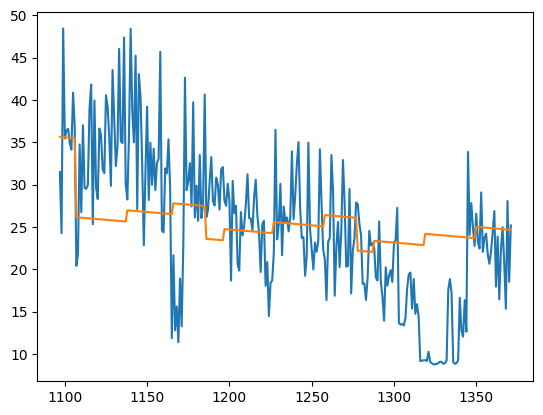

RSME: 7.8971619307605865


In [45]:
#Predykcja:
prediction_model_1 = model_1.predict(test_seasons[['Year', 'Month', 'Day', 'Season']])
prediction_model_1

# add prediction to test dataset
test_seasons['prediction_1'] = prediction_model_1

# plot prediction
from matplotlib import pyplot

pyplot.plot(test_seasons['Global_active_power'])
pyplot.plot(test_seasons['prediction_1'])
pyplot.show()

# calculate RMSE
rmse = mean_squared_error(test_seasons['Global_active_power'], prediction_model_1, squared=False)
print('RSME:' , rmse)

In [46]:
df_seasons_D.columns

Index(['Datestamp', 'Year', 'Month', 'Day', 'Season', 'Global_active_power',
       'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

In [47]:
#With dummies 

model_2 = LinearRegression()
model_2.fit(train_seasons[[ 'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
                           'Month_9', 'Month_10', 'Month_11', 'Month_12']], train_seasons['Global_active_power'])

LinearRegression()

In [48]:
print('wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_2: ', model_2.coef_)
print('wartość wyrazu wolnego modelu_1:', model_2.intercept_)

wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_2:  [-3.05023927e+14 -3.05023927e+14 -3.05023927e+14 -3.05023927e+14
 -3.27396905e+14 -3.27396905e+14 -3.27396905e+14 -3.27396905e+14
 -3.27396905e+14 -3.27396905e+14 -3.27396905e+14 -3.27396905e+14
 -3.27396905e+14 -3.27396905e+14 -3.27396905e+14 -3.27396905e+14]
wartość wyrazu wolnego modelu_1: 632420832340104.1


C:\Users\plhurno\AppData\Local\Temp\ipykernel_11788\2557488829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seasons['prediction_2'] = prediction_model_2


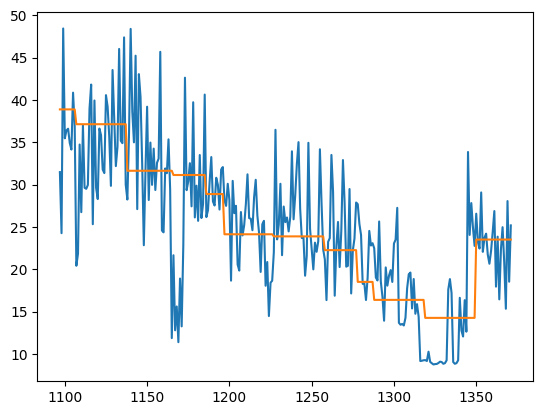

6.098130409596738


In [49]:
#Predykcja:
prediction_model_2 = model_2.predict(test_seasons[[ 'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
                           'Month_9', 'Month_10', 'Month_11', 'Month_12']])
prediction_model_2

# add prediction to test dataset
test_seasons['prediction_2'] = prediction_model_2

# plot prediction
#from matplotlib import pyplot

pyplot.plot(test_seasons['Global_active_power'])
pyplot.plot(test_seasons['prediction_2'])
pyplot.show()

# calculate RMSE
rmse = mean_squared_error(test_seasons['Global_active_power'], prediction_model_2, squared=False)
print(rmse)

In [50]:
model_3 = LinearRegression()
model_3.fit(train_seasons[[ 'Season', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
                           'Month_9', 'Month_10', 'Month_11', 'Month_12']], train_seasons['Global_active_power'])

LinearRegression()

In [51]:
print('wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_2: ', model_3.coef_)
print('wartość wyrazu wolnego modelu_1:', model_3.intercept_)

wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_2:  [-9.06202843e-01 -3.75011521e+14 -3.75011521e+14 -3.75011521e+14
 -3.75011521e+14 -3.75011521e+14 -3.75011521e+14 -3.75011521e+14
 -3.75011521e+14 -3.75011521e+14 -3.75011521e+14 -3.75011521e+14
 -3.75011521e+14]
wartość wyrazu wolnego modelu_1: 375011521346539.9


C:\Users\plhurno\AppData\Local\Temp\ipykernel_11788\3691189939.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seasons['prediction_3'] = prediction_model_3


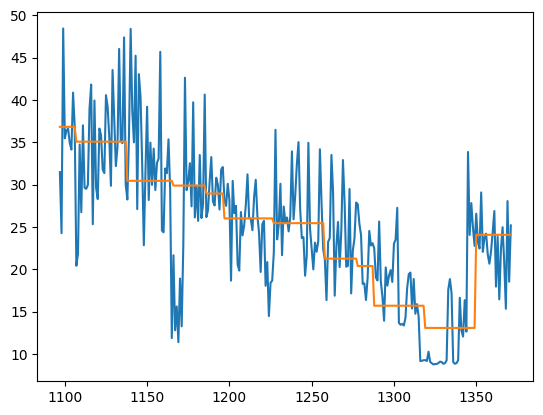

5.960080688900617


In [52]:
#Predykcja:
prediction_model_3 = model_3.predict(test_seasons[[ 'Season', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
                           'Month_9', 'Month_10', 'Month_11', 'Month_12']])
prediction_model_3

# add prediction to test dataset
test_seasons['prediction_3'] = prediction_model_3

# plot prediction
#from matplotlib import pyplot

pyplot.plot(test_seasons['Global_active_power'])
pyplot.plot(test_seasons['prediction_3'])
pyplot.show()

# calculate RMSE
rmse = mean_squared_error(test_seasons['Global_active_power'], prediction_model_3, squared=False)
print(rmse)

In [53]:
model_4 = LinearRegression()
model_4.fit(train_seasons[[ 'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Month']], train_seasons['Global_active_power'])

LinearRegression()

In [54]:
print('wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_2: ', model_4.coef_)
print('wartość wyrazu wolnego modelu_1:', model_4.intercept_)

wartości współczynników dla poszczególnych zmiennych niezależnych w modelu_2:  [-3.02954993e+14 -3.02954993e+14 -3.02954993e+14 -3.02954993e+14
  4.88689741e-01]
wartość wyrazu wolnego modelu_1: 302954993090753.8


C:\Users\plhurno\AppData\Local\Temp\ipykernel_11788\1442328861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seasons['prediction_4'] = prediction_model_4


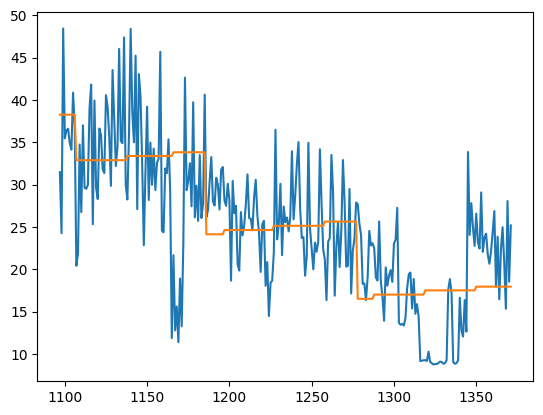

6.557313120180006


In [55]:
#Predykcja:
prediction_model_4 = model_4.predict(test_seasons[[ 'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Month']])
prediction_model_4

# add prediction to test dataset
test_seasons['prediction_4'] = prediction_model_4

# plot prediction
#from matplotlib import pyplot

pyplot.plot(test_seasons['Global_active_power'])
pyplot.plot(test_seasons['prediction_4'])
pyplot.show()

# calculate RMSE
rmse = mean_squared_error(test_seasons['Global_active_power'], prediction_model_4, squared=False)
print(rmse)

In [56]:
#Additive and multplicative solution:

model_5 = LinearRegression()
model_5.fit(train_seasons[['Season']], train_seasons[['Global_active_power']])

LinearRegression()

In [57]:
df_seasons_D.columns

Index(['Datestamp', 'Year', 'Month', 'Day', 'Season', 'Global_active_power',
       'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

In [58]:
train_seasons_1 = train_seasons[['Global_active_power', 'Year', 'Month', 'Day', 'Season']]

In [59]:
train_seasons_1['prediction_5'] = model_5.predict(train_seasons_1[['Season']])

C:\Users\plhurno\AppData\Local\Temp\ipykernel_11788\3841136411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seasons_1['prediction_5'] = model_5.predict(train_seasons_1[['Season']])


C:\Users\plhurno\AppData\Local\Temp\ipykernel_11788\2594125715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seasons_1['diff'] = train_seasons_1['Global_active_power'] - train_seasons_1['prediction_5']


<Axes: >

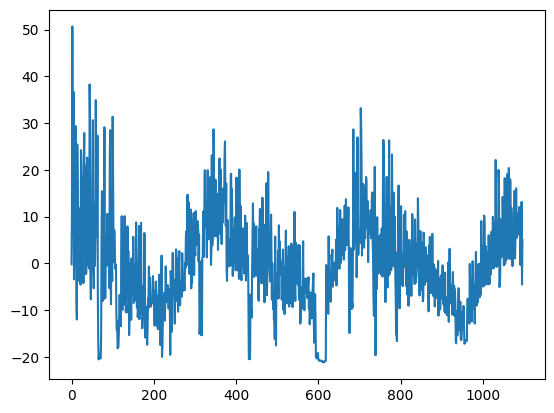

In [60]:
train_seasons_1['diff'] = train_seasons_1['Global_active_power'] - train_seasons_1['prediction_5']
train_seasons_1['diff'].plot()

C:\Users\plhurno\AppData\Local\Temp\ipykernel_11788\907864918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seasons_1['diff2'] = (train_seasons_1['Global_active_power'] - train_seasons_1['prediction_5'])/train_seasons_1['Global_active_power']


<Axes: >

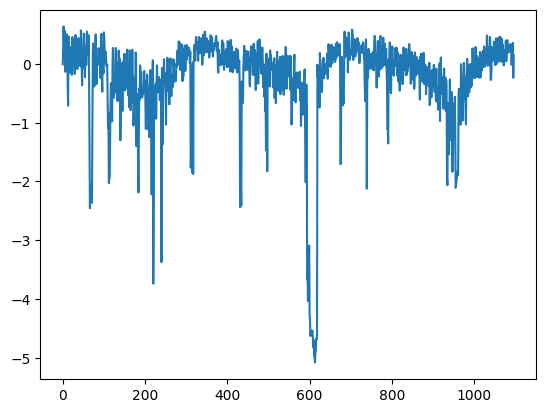

In [61]:
train_seasons_1['diff2'] = (train_seasons_1['Global_active_power'] - train_seasons_1['prediction_5'])/train_seasons_1['Global_active_power']
train_seasons_1['diff2'].plot()